In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.special import expit

np.random.seed(333)

# Gibbs sampling with refractory period

In [225]:
images = np.load('images_zca_norm.npy')
PFs = np.load('pfs.npy')

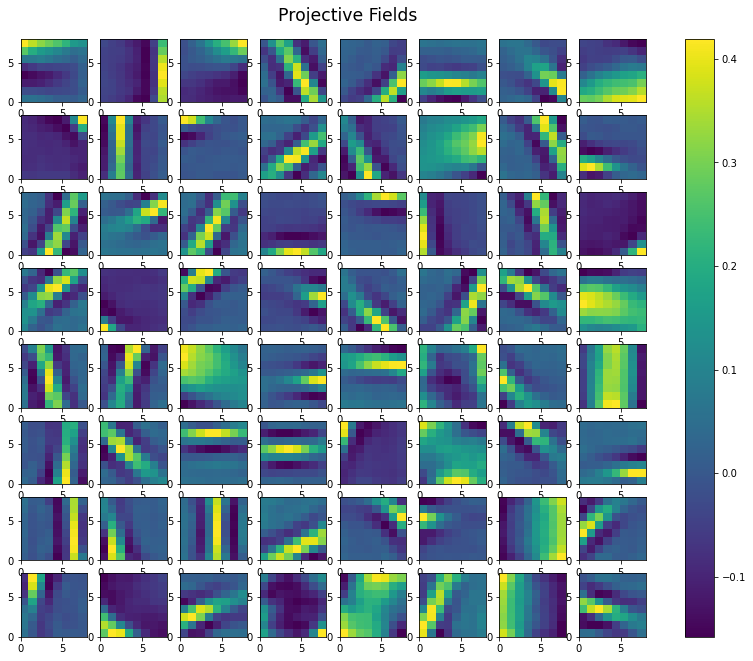

In [218]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(14, 11))

for i in range(8):
    for j in range(8):
        order = i*8 +j                             # neuron number
        ax = axes[i][j].pcolormesh(PFs[order])
        
fig.colorbar(ax, ax=axes[:, :], location='right')

fig.suptitle('Projective Fields', x = 0.45, y = 0.92, size = 'xx-large')

#fig.tight_layout(pad=3.0)
plt.show()

In [226]:
z_initial = np.random.binomial(1, 0.08, 64)     # Draw initial z vector from a Gaussian dist.
                                                # Here we used small probability to shorten the burn-in time
                                                # z defines if a neuron is firing or not, being either 1 or 0
Pf = np.transpose(PFs.reshape(64,64))           # Define weight matrix such as
                                                # every column corresponds to PF of the corresponding neuron
W = np.matmul(np.transpose(Pf[:,:]),Pf[:,:])    # Generate weight matrix 
Time = 1 #sec
delta_T = 0.001 #sec
N_sampling = int(Time/delta_T)                       # Sampling count = 400
tau = 5 #msec                                    Hard refractory period

In [159]:
def post_synaptic_potential(Image, i, z):
    weight_i = W[i]
    weight_i[i] = 0                                                    # w_ii = 0
    time_course = np.matmul(np.transpose(weight_i),z)                  # how other neurons contribute PSP now
    bias = np.matmul(np.transpose(Pf[:,i]),Image.reshape(64,1))        # regulation of own excitability
    return bias - time_course

In [160]:
def Gibbs_sampling(Image, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    ζ = np.zeros([64,n_sampling])                # accompanying matrix showing the refractory period
    ζ[:,0] = z_initial*tau                       # firing neurons get into refractory period
    
    for i in range(1, n_sampling):               # Start from the second column, and iterate through time
        response_matrix[:,i] = response_matrix[:,i-1]
        
###### Discuss whether we should update it syncronously or (in-line)
# they will effect each other in the same sampling if we do it in-line

        for j in range(64):                       
            if ζ[j, i-1] <= 1:                   # Make a draw if refractory period is end
                
                response_matrix[j, i] = 0
                transfer_ij = expit(post_synaptic_potential(Image, j, response_matrix[:,i])\
                                    - np.log(tau)) # expit for sigmoid fct
                response_matrix[j,i] = np.random.binomial(1, transfer_ij)
                
                if response_matrix[j,i] == 1:   # update refractory period
                    ζ[j, i] = tau                
                else:
                    ζ[j, i] = 0
                
            else:
                ζ[j, i] = ζ[j, i-1] - 1
   
    return response_matrix

In [199]:
a = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
np.shape(a)
a.reshape(3,4)
a

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [168]:
expit(post_synaptic_potential(Pf[:,8], 13, z_initial) - np.log(tau))

array([0.10216057])

In [161]:
def posterior_prob_r(Image, n_sampling):
    response = Gibbs_sampling(Image, n_sampling)
    return [np.sum(response[i])/n_sampling for i in range(64)]  # Return firing percentage

In [162]:
post_synaptic_potential(Pf[:,sample_neuron_number], 5, z_initial)

array([-0.13502682])

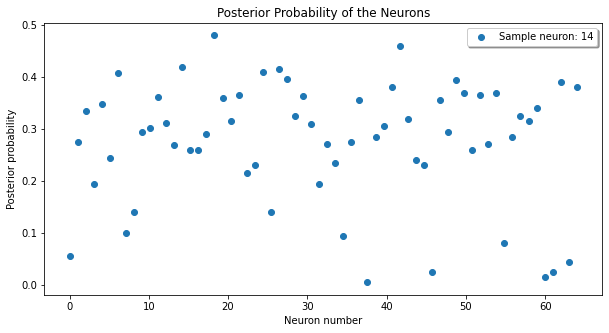

In [203]:
sample_neuron_number = 14
total_time = 1 #sec
sampling_rate = 1/5e-3
numberOFsampling = int(total_time*sampling_rate)
plt.figure(figsize = (10,5))
plt.scatter(np.linspace(0,64,64), posterior_prob_r(Pf[:,sample_neuron_number], N_sampling))
plt.title('Posterior Probability of the Neurons')
plt.xlabel('Neuron number')
plt.ylabel('Posterior probability')
plt.legend(["Sample neuron: %.0f" %sample_neuron_number], loc='upper right', fancybox=True, shadow=True)

Text(0, 0.5, 'Neuron number')

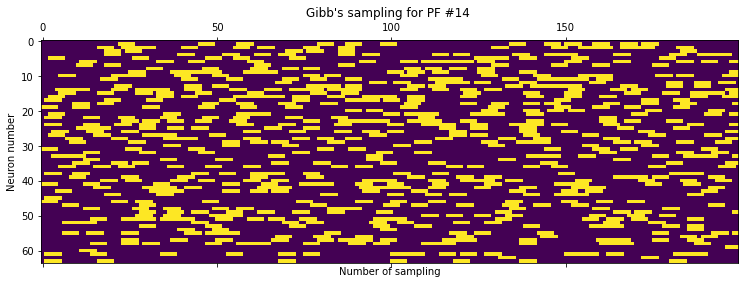

In [182]:
response = Gibbs_sampling(Pf[:,sample_neuron_number], numberOFsampling);

plt.matshow(response)
plt.title("Gibb's sampling for PF #%.f "%sample_neuron_number)
plt.xlabel("Number of sampling")
plt.ylabel('Neuron number')

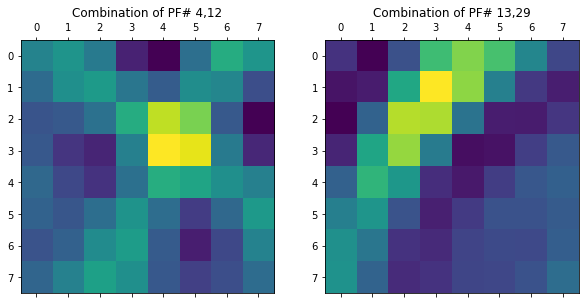

In [232]:
average_4_12 = (Pf[:,3].reshape(8,8)+Pf[:,11].reshape(8,8))/2
average_13_29 = (Pf[:,12].reshape(8,8)+Pf[:,28].reshape(8,8))/2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax = axes[0].matshow(average_4_12)
ax = axes[1].matshow(average_13_29)

axes[0].set_title('Combination of PF# 4,12')
axes[1].set_title('Combination of PF# 13,29')

plt.show()

In [231]:
PFs[3] == Pf[:,3].reshape(8,8)

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [184]:
def I_est(I, numberOFsampling):
    I_64 = I.reshape(64)
    posterior_array = posterior_prob_r(I_64, numberOFsampling)
    weighted_PFs = np.matmul(W,posterior_array)
    return weighted_PFs.reshape(8,8)

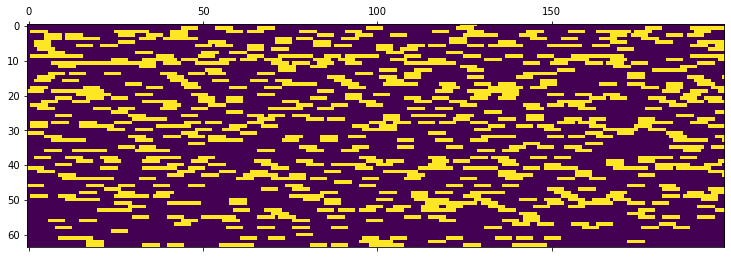

In [185]:
response_4_12 = Gibbs_sampling(average_4_12.reshape(64), numberOFsampling)
plt.matshow(response_4_12)

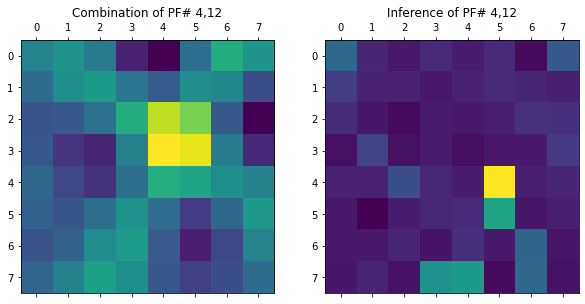

In [186]:
I_estimate_4_12 = I_est(average_4_12, numberOFsampling)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax = axes[0].matshow(average_4_12)
ax = axes[1].matshow(I_estimate_4_12)

axes[0].set_title('Combination of PF# 4,12')
axes[1].set_title('Inference of PF# 4,12')

plt.show()

In [230]:
Pf[:,5].reshape(8,8) == PFs[5]

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

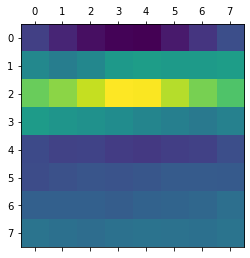

In [228]:
plt.matshow(Pf[:,5].reshape(8,8))

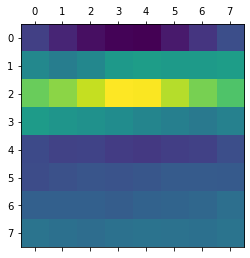

In [229]:
plt.matshow(PFs[5])

In [76]:
type(expit(1))

numpy.float64

In [60]:
a = z_initial*tau
for i in range(64):
    if a[i] <= 1:
        a[i] = 0
    else:
        a[i] = a[i] - 1
a

array([0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [69]:
1 == 1

True

In [67]:
expit(-1)

0.2689414213699951

In [7]:
a = [np.matmul(np.transpose(W[:,63]),W[:,i]) for i in range(64)]
np.shape(a)

(64,)

In [8]:
a = np.matmul(np.transpose(W[:,:]),W[:,63])
np.shape(a)

(64,)

In [ ]:
3 == 3

In [12]:
np.matmul(np.transpose(W[:,:]),W[:,1]) == np.matmul(np.transpose(W[:,:]),W[:,:])[:,1]

array([False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False,  True, False,  True,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True])

In [209]:
Ww = W
Ww[37,37] = 0

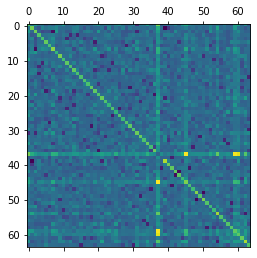

In [211]:
plt.matshow(W)

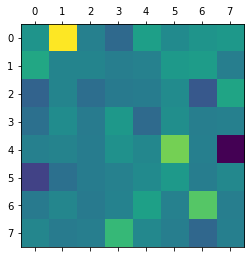

In [180]:
a = np.matmul(np.transpose(Pf[:,:]),Pf[:,:])
#a[1,1] = 0
plt.matshow(np.reshape(W[1], (8,8)))

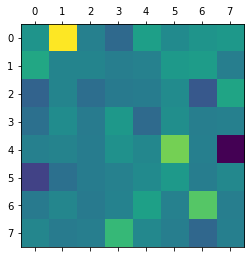

In [175]:
plt.matshow(np.reshape(np.matmul(np.transpose(Pf[:,:]),Pf[:,1]), (8,8)))